In [1]:
import numpy as np
import tensorflow as tf

2025-09-10 16:33:34.018014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2025-09-10 16:33:34.018030: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import numpy as np
import tensorflow as tf

def load_weather_npz_rowsplits(path="weather_data.npz"):
    z = np.load(path, allow_pickle=True)

    arrays_loaded = [np.asarray(a, dtype=np.float32) for a in z["arrays"]]
    lengths = np.asarray(z["lengths"], dtype=np.int64)

    # empilha todas as linhas (values) e monta os splits cumulativos
    values = np.vstack(arrays_loaded).astype(np.float32)     # [sum(T_i), F]
    row_splits = np.concatenate([[0], np.cumsum(lengths)])   # [N+1]

    data_tensor = tf.RaggedTensor.from_row_splits(
        values=tf.convert_to_tensor(values, dtype=tf.float32),
        row_splits=tf.convert_to_tensor(row_splits, dtype=tf.int64)
    )

    coords_tensor = tf.convert_to_tensor(z["coordinates"].astype(np.float32))
    features = list(z["features"])

    # (opcional) checar consistência
    F_tensor = int(data_tensor.shape[-1])
    if F_tensor != len(features):
        print(f"Aviso: tensor tem {F_tensor} colunas, features tem {len(features)} nomes.")

    return data_tensor, coords_tensor, features

# uso:
data_tensor, coords_tensor, features = load_weather_npz_rowsplits("weather_data.npz")


2025-09-10 16:33:35.256016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-09-10 16:33:35.258883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2025-09-10 16:33:35.258912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2025-09-10 16:33:35.258933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from typing import Optional, List

def plot_station_feature(
    data_tensor: tf.RaggedTensor,      # shape (N, None, F)
    coords_tensor: tf.Tensor,          # shape (N, D) (ex.: [lat, lon])
    features: List[str],               # nomes das F features (na ordem das colunas)
    station_index: int,                # qual estação plotar (0..N-1)
    feature_name: str,                 # nome exato da feature (ou parecido; ver abaixo)
    timestamps: Optional[List[np.ndarray]] = None,  # opcional: lista de vetores de tempo por estação
    title_prefix: str = ""
):
    N = int(data_tensor.nrows().numpy())
    if not (0 <= station_index < N):
        raise IndexError(f"station_index fora do intervalo: 0..{N-1}")

    # Encontrar a coluna da feature (com tolerância a nome "parecido")
    if feature_name not in features:
        import difflib
        sugest = difflib.get_close_matches(feature_name, features, n=1, cutoff=0.0)
        if not sugest:
            raise ValueError(f"Feature '{feature_name}' não encontrada. Exemplos: {features[:8]} ...")
        feature_name = sugest[0]
    k = features.index(feature_name)

    # Série temporal: estação 'i' e coluna 'k'
    y_raw = data_tensor[station_index][:, k].numpy()   # shape (T_i,)
    mask = np.isfinite(y_raw)
    y = y_raw[mask]

    # Eixo temporal
    if timestamps is not None and len(timestamps) == N:
        t_full = np.asarray(timestamps[station_index])
        t = t_full[mask]
        xlab = "Tempo"
    else:
        t = np.arange(len(y))
        xlab = "Índice temporal"

    # Coordenadas para o título (se houver ao menos 2 dims)
    try:
        coord = coords_tensor[station_index].numpy()
        if coord.size >= 2:
            coord_txt = f"(lat={coord[0]:.4f}, lon={coord[1]:.4f})"
        else:
            coord_txt = ""
    except Exception:
        coord_txt = ""

    # Plot
    plt.figure()
    plt.plot(t, y)
    prefix = f"{title_prefix} - " if title_prefix else ""
    plt.title(f"{prefix}Estação #{station_index} {coord_txt} — {feature_name}")
    plt.xlabel(xlab)
    plt.ylabel(feature_name)
    plt.tight_layout()
    plt.show()


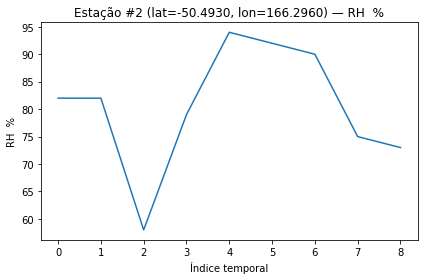

In [4]:
plot_station_feature(data_tensor, coords_tensor, features,
                     station_index=2, feature_name="RH")

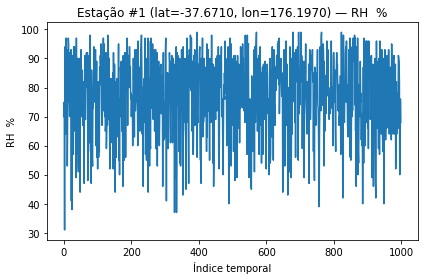

In [5]:
plot_station_feature(data_tensor, coords_tensor, features,
                     station_index=1, feature_name="RH")

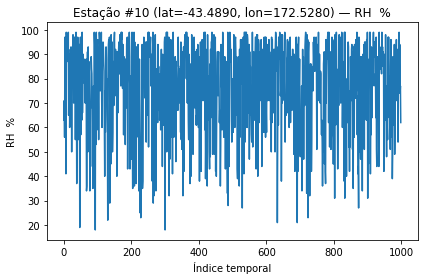

In [6]:
plot_station_feature(data_tensor, coords_tensor, features,
                     station_index=10, feature_name="RH")